In [100]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import netCDF4 as nc
from netCDF4 import Dataset
from pyproj import Proj, Transformer, CRS
from pyproj.aoi import AreaOfInterest
from pyproj.database import query_utm_crs_info
import plotly as py
from plotly.graph_objs import *
from scipy.io import netcdf
from mpl_toolkits.basemap import Basemap
import plotly.express as px
import plotly.graph_objects as go
from metpy.calc import relative_humidity_from_specific_humidity
from metpy.units import units
import seaborn as sns
from osgeo import gdal
from shapely.geometry import Point
import scipy as sp
import rasterio
from utils_exploration import GeoTsObject
import rioxarray
import xarray as xr
import numpy as np
import gemgis as gg
import regionmask

In [2]:
geo_ts = GeoTsObject()

In [48]:
tair_ds = xr.open_mfdataset(geo_ts.tair_path, format = 'NETCDF4')
rainf_ds = xr.open_mfdataset(geo_ts.rainf_path, format = 'NETCDF4')
snowf_ds = xr.open_mfdataset(geo_ts.snowf_path, format = 'NETCDF4')
psurf_ds = xr.open_mfdataset(geo_ts.psurf_path, format = 'NETCDF4')
qair_ds = xr.open_mfdataset(geo_ts.qair_path, format = 'NETCDF4')
wind_ds = xr.open_mfdataset(geo_ts.wind_path, format = 'NETCDF4')
swdown_ds = xr.open_mfdataset(geo_ts.swdown_path, format = 'NETCDF4')
# Discharge dataset
discharge_df = pd.read_csv(geo_ts.discharge_path, header= 16)
discharge_df = discharge_df.rename(columns = {' 2015 ' : 'daily_flow'})
discharge_df.index = pd.to_datetime(discharge_df.index)
discharge_ds = discharge_df.to_xarray()
# Cell data
cell_data_ds = xr.open_mfdataset(geo_ts.cell_data_path, format = 'NETCDF4')

In [4]:
x = cell_data_ds.x.values
y = cell_data_ds.y.values

catchment_id = cell_data_ds.catchment_id.values

In [5]:
# Get lat and lon to extract from WFDE5

## Making a pyproj object for UTM Zone 45N

crs_32645 = CRS.from_epsg(32645) # CRS from cell_data file
crs_4326 = CRS.from_epsg(4326) # Lat-lon


## Create transformer to convert from CRS to CRS

transformer = Transformer.from_crs(crs_32645, crs_4326, always_xy = True)

lon, lat = transformer.transform(x, y)

lon.sort()
lat.sort()

In [6]:
# Min and max cooridnates to extract from

min_lon = lon.min()
print(f'Min lon: {min_lon}')
min_lat = lat.min()
print(f'Min lat: {min_lat}')
max_lon = lon.max()
print(f'Max lon: {max_lon}')
max_lat = lat.max()
print(f'Max lat: {max_lat}')

Min lon: 82.8860627875782
Min lat: 27.639464651636498
Max lon: 85.78765946343044
Max lat: 29.32421532572714


In [7]:
# Bounding box (coordinates rounded down to nearest values in WFDE5 and made such that the number of dimensions are the same)
min_lon = 82.75
min_lat = 25.75
max_lon = 88.25
max_lat = 31.25

In [49]:
# Get only data contained within these lat, lon coordinates
psurf_ds = psurf_ds.sel(lon = slice(min_lon, max_lon), lat = slice(min_lat, max_lat)).copy()
wind_ds = wind_ds.sel(lon = slice(min_lon, max_lon), lat = slice(min_lat, max_lat)).copy()
tair_ds = tair_ds.sel(lon = slice(min_lon, max_lon), lat = slice(min_lat, max_lat)).copy()
rainf_ds = rainf_ds.sel(lon = slice(min_lon, max_lon), lat = slice(min_lat, max_lat)).copy()
snowf_ds = snowf_ds.sel(lon = slice(min_lon, max_lon), lat = slice(min_lat, max_lat)).copy()
qair_ds = qair_ds.sel(lon = slice(min_lon, max_lon), lat = slice(min_lat, max_lat)).copy()
swdown_ds = swdown_ds.sel(lon = slice(min_lon, max_lon), lat = slice(min_lat, max_lat)).copy()


In [50]:
# Scaling of variables

## Temperature
T_degc = tair_ds.Tair - 273.15
tair_ds = tair_ds.assign(Tair_degc= T_degc)

# Precipitation
Precip = rainf_ds.Rainf * 3600 + snowf_ds.Snowf * 3600
rainf_ds = rainf_ds.assign(Precip = Precip)

# Pressure
PSurf_hpa = psurf_ds.PSurf * 0.01
psurf_ds = psurf_ds.assign(PSurf_hpa = PSurf_hpa)

In [51]:
n = int(len(qair_ds.Qair) / 2)
tn_1 = qair_ds.isel(time = slice(0, n)).time.values
tn_2 = qair_ds.isel(time = slice(n, 2 * n)).time.values

In [52]:
rel_hum_1 = relative_humidity_from_specific_humidity(psurf_ds.PSurf_hpa.sel(time = tn_1).values * units.hPa, tair_ds.Tair_degc.sel(time = tn_1).values * units.degC, qair_ds.Qair.sel(time = tn_1).values).to('percent').magnitude

In [53]:
rel_hum_2 = relative_humidity_from_specific_humidity(psurf_ds.PSurf_hpa.sel(time = tn_2).values * units.hPa, tair_ds.Tair_degc.sel(time = tn_2).values * units.degC, qair_ds.Qair.sel(time = tn_2).values).to('percent').magnitude

In [54]:
rel_hum = np.append(rel_hum_1, rel_hum_2).reshape(2 * n, 12, 12)
rel_hum = rel_hum * 0.01

In [55]:

# Relative humidity

qair_ds = qair_ds.assign(relative_humidity = (['time', 'lon', 'lat'], rel_hum))

In [21]:
# Convert from lon, lat to x, y

# First we extract the longitudes and latitudes for the clusters 
# (variables have dimension ('time', 'clusters'))

lon_qair = qair_ds.lon.values
lat_qair = qair_ds.lat.values

In [22]:
qair_stacked = qair_ds.stack(station = ['lon', 'lat']).copy()

In [23]:
# Making a list with a tuple of all (lon, lat) points

stations = qair_stacked.station.values

In [24]:
# Now we need to convert the list of tuples to a list of Point objects

points = []
for i in range(len(stations)):
    points.append(Point((stations[i][0], stations[i][1])))

In [ ]:
# Now we need to convert the list of tuples to a list of Point objects

points = []
for i in range(len(stations)):
    points.append(Point((stations[i][0], stations[i][1])))

In [25]:
# Make a GeoPandas dataframe with all the clusters and points
gdf = gpd.GeoDataFrame(np.arange(len(points)), geometry = points, crs = 4326)

In [26]:
# Make a list of all the points (lon, lat)
coord_list = [(x,y) for x,y in zip(gdf['geometry'].x , gdf['geometry'].y)]

In [27]:
# To get altitude DEM tiles from USGS are merged into one DEM using QGIS and CRS: 4326

## Opening this merged DEM

dem_dataset = rasterio.open('/Users/jacobqs/Documents/MST Himalaya/qgis/DEM/merged_DEM_central_himalaya.tif')

In [28]:
# Sample the coordinate points in coord_list in the DEM file
gdf['value'] = [x for x in dem_dataset.sample(coord_list)]

In [29]:
# Getting a list of all z values
z = []
for i in gdf['value'].values:
    z.append(i[0].astype('float64'))


In [36]:
z_transpose = np.reshape(z, (12,12)).T

In [57]:
z_transpose

array([[  83.,   78.,   70.,   58.,   55.,   53.,   52.,   43.,   42.,
          41.,   40.,   34.],
       [  89.,   77.,   69.,   65.,   63.,   62.,   56.,   58.,   60.,
          60.,   54.,   62.],
       [  83.,   81.,   84.,   80.,   72.,   78.,   77.,  107.,  176.,
         179.,  258.,  194.],
       [  92.,   84.,  100.,  115.,  176.,  558.,  302.,  410., 1727.,
        1049., 1219.,  950.],
       [ 597.,  284., 1320.,  689., 1258., 2083., 1545., 2238., 4446.,
        3919., 4590., 4924.],
       [1145., 2039., 1376., 1457., 2163., 4063., 6612., 5544., 6006.,
        5235., 4407., 4398.],
       [3953.,    0., 3322., 4855., 4381., 4773., 4667., 4965., 4586.,
        4785., 4824., 5430.],
       [   0., 4800., 5639., 5159., 4532., 4598., 4549., 4755., 4702.,
        4663., 3985., 4337.],
       [5299., 4646., 4679., 5143., 5120., 5854., 5303., 4880., 5251.,
        5096., 4509., 5639.],
       [4874., 4665., 5005., 5381., 5198., 5554., 5368., 5752., 4869.,
        5043., 4939.

In [59]:
tair_ds = tair_ds.assign_coords(z = (('lon', 'lat'), z_transpose))
rainf_ds = rainf_ds.assign_coords(z = (('lon', 'lat'), z_transpose))
snowf_ds = snowf_ds.assign_coords(z = (('lon', 'lat'), z_transpose))
wind_ds = wind_ds.assign_coords(z = (('lon', 'lat'), z_transpose))
qair_ds = qair_ds.assign_coords(z = (('lon', 'lat'), z_transpose))
swdown_ds = swdown_ds.assign_coords(z = (('lon', 'lat'), z_transpose))

In [64]:
## Making a pyproj object for UTM Zone 45N

lons = tair_ds.lon.values
lats = tair_ds.lat.values

crs_4326 = CRS.from_epsg(4326) # Lat-lon
crs_32645 = CRS.from_epsg(32645) # CRS 

## Create transformer to convert from CRS to CRS

transformer = Transformer.from_crs(crs_4326, crs_32645, always_xy = True)

x, y = transformer.transform(lons, lats)

In [62]:
tair_ds = tair_ds.assign_coords({'x':x, 'y':y})
rainf_ds = rainf_ds.assign_coords({'x':x, 'y':y})
snowf_ds = snowf_ds.assign_coords({'x':x, 'y':y})
wind_ds = wind_ds.assign_coords({'x':x, 'y':y})
qair_ds = qair_ds.assign_coords({'x':x, 'y':y})
swdown_ds = swdown_ds.assign_coords({'x':x, 'y':y})

In [63]:
swdown_ds

<xarray.Dataset>
Dimensions:  (lon: 12, lat: 12, time: 262968, x: 12, y: 12)
Coordinates:
  * lon      (lon) float64 82.75 83.25 83.75 84.25 ... 86.75 87.25 87.75 88.25
  * lat      (lat) float64 25.75 26.25 26.75 27.25 ... 29.75 30.25 30.75 31.25
  * time     (time) datetime64[ns] 1990-01-01 ... 2019-12-31T23:00:00
    z        (lon, lat) float64 83.0 78.0 70.0 ... 4.839e+03 5.047e+03 4.937e+03
  * x        (x) float64 7.353e+04 1.253e+05 1.767e+05 ... 5.718e+05 6.19e+05
  * y        (y) float64 2.855e+06 2.909e+06 2.963e+06 ... 3.402e+06 3.458e+06
Data variables:
    SWdown   (time, lat, lon) float32 dask.array<chunksize=(744, 12, 12), meta=np.ndarray>
Attributes:
    title:        WATCH Forcing Data methodology applied to ERA5 data
    institution:  Copernicus Climate Change Service
    contact:      http://copernicus-support.ecmwf.int
    comment:      Methodology implementation for ERA5 and dataset production ...
    Conventions:  CF-1.7
    summary:      ERA5 data regridded to half degree regular lat-lon; Genuine...
    reference:    Cucchi et al., 2020, Earth Syst. Sci. Data, 12(3), 2097–212...
    licence:      The dataset is distributed under the Licence to Use Coperni...

In [72]:
ds_temperature = xr.Dataset(
    data_vars = dict(
        temperature = (['time', 'x', 'y'], tair_ds.Tair_degc.values.astype('float64'))
    ),
    coords = dict(
        time = (['time'], tair_ds.time.values),
        x = (['x'], tair_ds.x.values),
        y = (['y'], tair_ds.y.values),
        z = (['x', 'y'], tair_ds.z.values)
    )  
)

In [9]:
budhi_gandaki_shp = gpd.read_file(geo_ts.budhi_gandaki_shp_path)

In [80]:
budhi_gandaki_shp = budhi_gandaki_shp.to_crs('32645')

In [103]:
polygon = budhi_gandaki_shp.geometry

In [105]:
region_object = regionmask.Regions(polygon)

In [106]:
mask = region_object.mask(ds_temperature.isel(time = 0), lat_name = 'y', lon_name = 'x')

/var/folders/07/3pj74xcs7mqdgyzchd88y9840000gn/T/ipykernel_99041/955003313.py:1: UserWarning: No gridpoint belongs to any region. Returning an all-NaN mask.
  mask = region_object.mask(ds_temperature.isel(time = 0), lat_name = 'y', lon_name = 'x')


In [108]:
ds_temperature

<xarray.Dataset>
Dimensions:      (time: 262968, x: 12, y: 12)
Coordinates:
  * time         (time) datetime64[ns] 1990-01-01 ... 2019-12-31T23:00:00
  * x            (x) float64 7.353e+04 1.253e+05 ... 5.718e+05 6.19e+05
  * y            (y) float64 2.855e+06 2.909e+06 ... 3.402e+06 3.458e+06
    z            (x, y) float64 83.0 78.0 70.0 ... 4.839e+03 5.047e+03 4.937e+03
Data variables:
    temperature  (time, x, y) float64 7.229 7.482 8.125 ... -18.97 -17.82 -15.95

In [115]:
masked_temp_ds = ds_temperature.temperature.where(mask != np.nan)

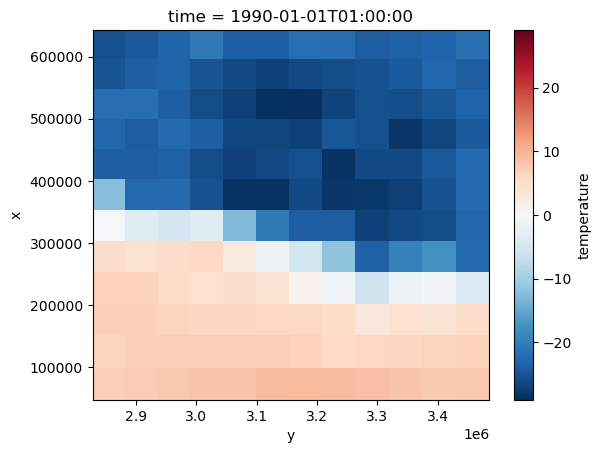

In [116]:
masked_temp_ds.isel(time=1).plot()